In [ ]:
#Task 3.1 (a) (b) (c) (d)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Define Architecture (from your provided code)
class VAE(nn.Module):
    def __init__(self, input_dim, h_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, h_dim)
        self.fc2_mu = nn.Linear(h_dim, latent_dim)
        self.fc2_logvar = nn.Linear(h_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 2. Define Loss Function
def vae_loss_function(x, x_reconstructed, mu, logvar):
    # BCE measures reconstruction quality
    reconstruction_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    # KL Divergence regularizes the latent space
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_loss

# 3. Data Loading & Hyperparameters
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

train_loader = DataLoader(datasets.FashionMNIST('./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
val_loader = DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transform), batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=784, h_dim=400, latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Training Loop
epochs = 15
history = {'train_loss': [], 'val_loss': []}

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss_function(data, recon, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_train = train_loss / len(train_loader.dataset)
    history['train_loss'].append(avg_train)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            val_loss += vae_loss_function(data, recon, mu, logvar).item()
    
    avg_val = val_loss / len(val_loader.dataset)
    history['val_loss'].append(avg_val)
    print(f'Epoch {epoch+1}: Train {avg_train:.2f} | Val {avg_val:.2f}')

Epoch 1: Train 284.12 | Val 262.29
Epoch 2: Train 256.08 | Val 254.36
Epoch 3: Train 250.54 | Val 250.60
Epoch 4: Train 247.82 | Val 248.53
Epoch 5: Train 246.23 | Val 247.26
Epoch 6: Train 245.10 | Val 246.58
Epoch 7: Train 244.33 | Val 245.56
Epoch 8: Train 243.64 | Val 245.26
Epoch 9: Train 243.15 | Val 244.78
Epoch 10: Train 242.73 | Val 245.74
Epoch 11: Train 242.31 | Val 244.06
Epoch 12: Train 242.01 | Val 243.57
Epoch 13: Train 241.78 | Val 243.90
Epoch 14: Train 241.56 | Val 243.36
Epoch 15: Train 241.32 | Val 242.89


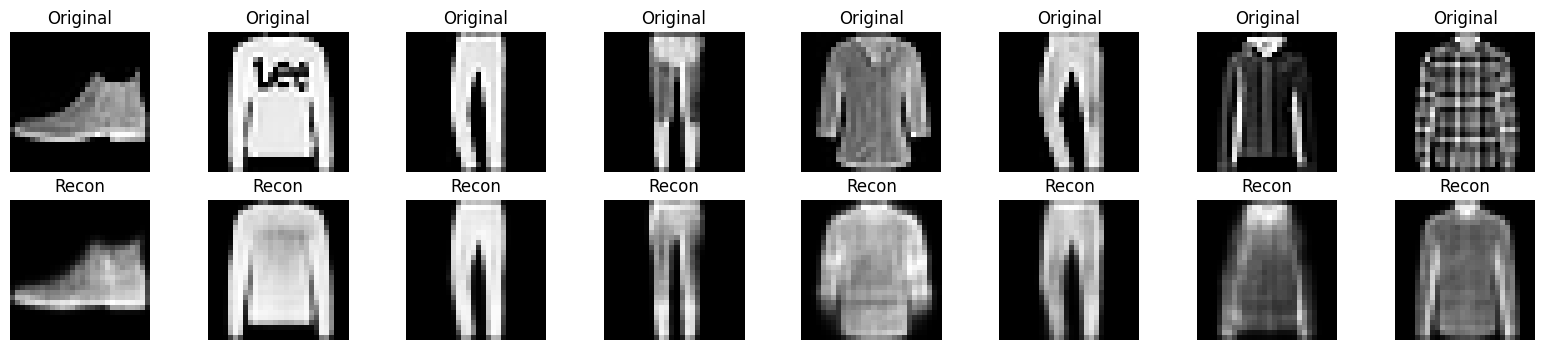

In [3]:
#Task 3.2 (a)

import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # Get a batch of test images
    data, _ = next(iter(val_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    # Plotting
    n = 8  # Number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title("Recon")
        plt.axis('off')
    plt.show()

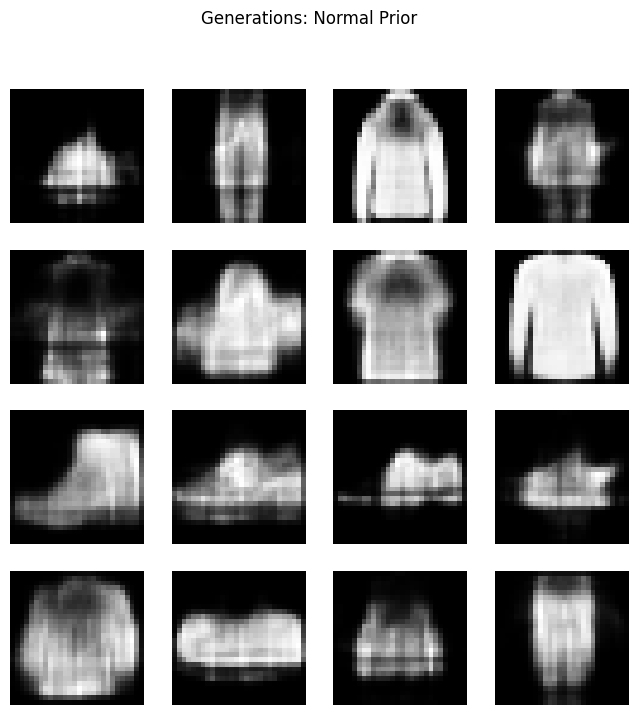

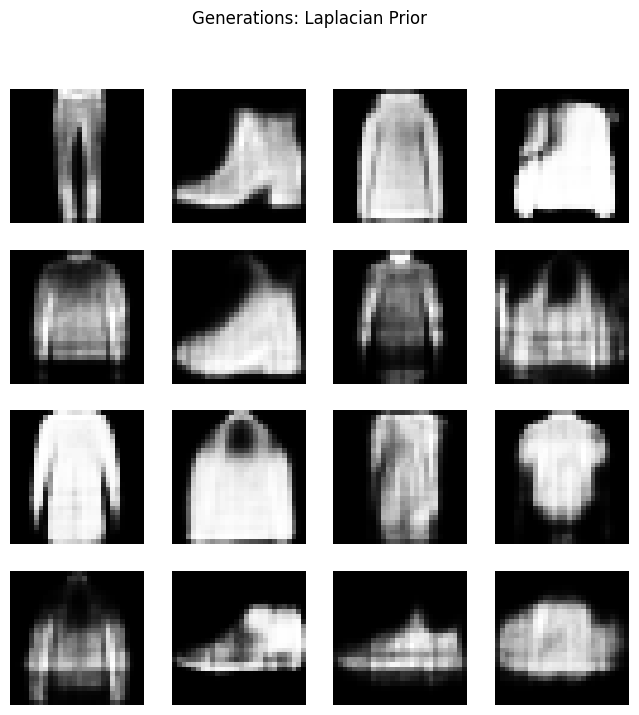

In [ ]:
#Task 3.2 (b) (c)

with torch.no_grad():
    # (b) Sample from standard Normal Prior
    z_normal = torch.randn(16, latent_dim).to(device)
    sample_normal = model.decode(z_normal).cpu()

    # (c) Sample from Laplacian Prior (scale=1.0)
    # Using a different distribution not seen during training
    m = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0]))
    z_laplace = m.sample((16, latent_dim)).squeeze().to(device)
    sample_laplace = model.decode(z_laplace).cpu()

# Helper function to plot samples
def plot_samples(samples, title):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_samples(sample_normal, "Generations: Normal Prior")
plot_samples(sample_laplace, "Generations: Laplacian Prior")

In [6]:
#Task 3.4

beta = 0.0
iteration = 0
warmup_steps = 5 * len(train_loader)
history_annealed = {'loss': []}

print(f"Starting training with KL Annealing...")

for epoch in range(15):
    model.train()
    total_epoch_loss = 0
    
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        beta = min(1.0, iteration / warmup_steps)
        recon, mu, logvar = model(data)
        
        recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        total_loss = recon_loss + (beta * kl_loss)
        total_loss.backward()
        optimizer.step()
        
        total_epoch_loss += total_loss.item()
        iteration += 1
    
    avg_loss = total_epoch_loss / len(train_loader.dataset)
    history_annealed['loss'].append(avg_loss)
    
    # This will give us the output to discuss
    print(f"Epoch [{epoch+1}/15] | Beta: {beta:.2f} | Avg Loss: {avg_loss:.2f}")

Starting training with KL Annealing...
Epoch [1/15] | Beta: 0.20 | Avg Loss: 219.31
Epoch [2/15] | Beta: 0.40 | Avg Loss: 224.75
Epoch [3/15] | Beta: 0.60 | Avg Loss: 229.63
Epoch [4/15] | Beta: 0.80 | Avg Loss: 233.85
Epoch [5/15] | Beta: 1.00 | Avg Loss: 237.59
Epoch [6/15] | Beta: 1.00 | Avg Loss: 239.27
Epoch [7/15] | Beta: 1.00 | Avg Loss: 239.17
Epoch [8/15] | Beta: 1.00 | Avg Loss: 239.12
Epoch [9/15] | Beta: 1.00 | Avg Loss: 239.03
Epoch [10/15] | Beta: 1.00 | Avg Loss: 239.02
Epoch [11/15] | Beta: 1.00 | Avg Loss: 238.93
Epoch [12/15] | Beta: 1.00 | Avg Loss: 238.87
Epoch [13/15] | Beta: 1.00 | Avg Loss: 238.87
Epoch [14/15] | Beta: 1.00 | Avg Loss: 238.79
Epoch [15/15] | Beta: 1.00 | Avg Loss: 238.77
